In [1]:
%run init_notebook.py

In [2]:
from yahoo_fin import stock_info as ysi
# link to yahoo_fin docs: http://theautomatic.net/yahoo_fin-documentation/
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pandas_ta as ta

import datetime as dt

In [3]:
X = ysi.tickers_sp500()

In [19]:
x = ysi.get_day_losers()
# ysi.tickers_sp500()

In [20]:
ysi.get_postmarket_price

,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
0,BILI,Bilibili Inc.,19.5200,-4.1000,-17.36,20696000.0,5199000.0,7.475000e+09,NaN
1,MDDNF,Meridian Energy Limited,2.8500,-0.4300,-13.11,17155.0,22.0,6.801000e+09,25.91
2,TWODF,Taylor Wimpey plc,1.2700,-0.1300,-9.29,40255.0,1003.0,4.045000e+09,6.68
3,GSAT,"Globalstar, Inc.",1.8747,-0.1853,-9.00,29582000.0,7628000.0,3.376000e+09,NaN
4,SABR,Sabre Corporation,6.6000,-0.6300,-8.72,8860000.0,6849000.0,2.166000e+09,NaN
...,...,...,...,...,...,...,...,...,...
95,KLBAY,Klabin S.A.,6.9900,-0.2100,-2.99,21923.0,2117.0,1.921600e+10,26.87
96,LI,Li Auto Inc.,25.9300,-0.7300,-2.74,6020000.0,11676000.0,2.566400e+10,2593.00
97,KRYAY,Kerry Group plc,98.7100,-2.8100,-2.77,21400.0,19082.0,1.746600e+10,22.85
98,CPAMF,CapitaLand Integrated Commercial Trust,1.4100,-0.0400,-2.76,49800.0,12229.0,9.533000e+09,10.85


In [5]:
x = X[50:].copy()

In [7]:
def apply_datetime_format(x,
                          ret_time: bool = False,
                          europe_time_slash: bool = False):
    """
    Function applies datetime format to any given string
    :param x: datetime string
    :param ret_time: return datetime or date only
    :param europe_time_slash: should "/" be intepreted as european or american - month/day vs. day/month
    :return: datetime format
    """
    x = str(x)
    try:
        x = dt.datetime.strptime(x, "%Y-%m-%d")
        if ret_time is False:
            return x.date()
    except ValueError:
        pass

    try:
        x = dt.datetime.strptime(x, "%d.%m.%Y")
        if ret_time is False:
            return x.date()
    except ValueError:
        pass

    try:
        x = dt.datetime.strptime(x, "%d.%m.%Y")
        if ret_time is False:
            return x.date()
    except ValueError:
        pass

    try:
        if europe_time_slash:
            x = dt.datetime.strptime(x, "%d/%m/%Y")
        else:
            x = dt.datetime.strptime(x, "%m/%d/%Y")
        if ret_time is False:
            return x.date()
    except ValueError:
        pass

    try:
        x = dt.datetime.strptime(x, "%Y%m%d")
        if ret_time is False:
            return x.date()
    except ValueError:
        pass

    try:
        x = dt.datetime.strptime(x, "%m.%d.%Y %H:%M:%S")
        if ret_time is False:
            return x.date()
    except ValueError:
        pass

    try:
        x = dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
        if ret_time is False:
            return x.date()
    except ValueError:
        pass

    try:
        x = dt.datetime.strptime(x, "%Y/%m/%d %H:%M:%S")
        if ret_time is False:
            return x.date()
    except ValueError:
        pass

    try:
        x = dt.datetime.strptime(x, "%m/%d/%Y %H:%M:%S")
        if ret_time is False:
            return x.date()
    except ValueError:
        pass

    try:
        x = dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
        if ret_time is False:
            return x.date()
    except ValueError:
        pass

    raise ValueError(f"{x} format unknonw")

In [8]:
def get_log_returns(arr: float):
    return np.log(1 + arr.pct_change())

def get_ticker_data(ticker: str,
                    start_date: str,
                    end_date: dt.datetime = dt.datetime.now().date()):
    
    start_date = apply_datetime_format(start_date)
    
    df = ysi.get_data(ticker, start_date, end_date) # get data
    df['ret_close'] = get_log_returns(df.close) # close log returns

    df = df.reset_index().rename(columns={'index': 'date'})
    
    return df

def get_macd(df_in: pd.DataFrame,
             fast: int = 12,
             slow: int = 26,
             signal: int = 9):
    
    df = df_in.copy()
    df.ta.macd(close='close', fast=fast, slow=slow, signal=signal, append=True); # macd
    df.rename(columns={f"MACD_{fast}_{slow}_{signal}": 'macd',
                       f"MACDh_{fast}_{slow}_{signal}": 'macdh',
                       f"MACDs_{fast}_{slow}_{signal}": 'macds'}, inplace=True)

    df['is_macd_hold'] = df['macd'].apply(lambda x: True if x > 0 else False)
    return df
    
def get_wr(df_in: pd.DataFrame,
           high: str,
           low: str,
           close: str,
           lookback: int):
    df = df_in.copy()
    
    highh = df[high].rolling(lookback).max() 
    lowl = df[low].rolling(lookback).min()
    df['williamsr'] = -100 * ((highh - df[close]) / (highh - lowl))
    
    return df['williamsr'] * -1

In [9]:
def long_short_portfolio(df_in: pd.DataFrame,
                         is_hold: str,
                         log_rets: str,
                         port_val: int,
                         trading_fee: float = 1,
                         short_leverage: float = 1):
    df = df_in.copy()
    
    port_name = 'port'
    
    df[port_name] = list([0]*len(df))
    df.loc[0, port_name] = port_val
    df.loc[1, port_name] = port_val
        
    for i in df.index[1:]:
        
        # long portfolio
        if df.loc[i, is_hold] == True:
            df.loc[i+1, port_name] = df.loc[i, port_name] * (1 + df.loc[i, log_rets])
            
            # if prior period was short impose trading fee * 2 (selling short portfolio - buying long portfolio)
            if df.loc[i-1, is_hold] == False:
                df.loc[i+1, port_name] = df.loc[i+1, port_name] - trading_fee*2
        
        # short portfolio
        elif df.loc[i, is_hold] == False:
            df.loc[i+1, port_name] = df.loc[i, port_name] * (1 - (df.loc[i, log_rets] * short_leverage))

            # if prior period was long impose trading fee * 2 (selling long portfolio - buying short portfolio)
            if df.loc[i-1, is_hold] == True:
                df.loc[i+1, port_name] = df.loc[i+1, port_name] - trading_fee*2
                               
    return df[port_name]

def long_sell_portfolio(df_in: pd.DataFrame,
                         is_hold: str,
                         log_rets: str,
                         port_val: int,
                         trading_fee: float = 1):
    df = df_in.copy()
    
    port_name = 'port_long_sell'
    
    df[port_name] = list([0]*len(df))
    df.loc[0, port_name] = port_val
    df.loc[1, port_name] = port_val
    
    for i in df.index[1:-1]:
        
        # long portfolio holding long portfolio
        if df.loc[i, is_hold] == True:
            df.loc[i+1, port_name] = df.loc[i, port_name] * (1 + df.loc[i, log_rets])
            
            # if prior period was sell, impose trading fee * 1 (selling long portfolio)
            if df.loc[i-1, is_hold] == False:
                df.loc[i+1, port_name] = df.loc[i+1, port_name] - trading_fee*1
                       
        # selling long portfolio and holding returns
        if df.loc[i, is_hold] == False:
            df.loc[i+1, port_name] = df.loc[i, port_name]

            # if prior period was long impose trading fee * 1 (selling long portfolio)
            if df.loc[i-1, is_hold] == True:
                df.loc[i+1, port_name] = df.loc[i+1, port_name] - trading_fee*1
                               
    return df[port_name]

def long_hedge_portfolio(df_in: pd.DataFrame,
                         is_hold: str,
                         log_rets: str,
                         port_val: int,
                         trading_fee: float = 1,
                         hedge_leverage: float = 1):
    df = df_in.copy()
    
    port_name = 'port'
    
    df[port_name] = list([0]*len(df))
    df.loc[0, port_name] = port_val
    df.loc[1, port_name] = port_val
    
    
    for i in df.index[1:]:
        
        # long portfolio holding long portfolio
        if df.loc[i, is_hold] == True:
            df.loc[i+1, port_name] = df.loc[i, port_name] * (1 + df.loc[i, log_rets])
            
            # if prior period was short impose trading fee * 1 (selling short portfolio)
            if df.loc[i-1, is_hold] == False:
                df.loc[i+1, port_name] = df.loc[i+1, port_name] - trading_fee*1
                       
        # hedge: buying short portfolio on top of long portfolio to offset losses
        if df.loc[i, is_hold] == False:
            df.loc[i+1, port_name] = df.loc[i, port_name] * (1 + df.loc[i, log_rets]) - df.loc[i, port_name] * (df.loc[i, log_rets] * hedge_leverage)

            # if prior period was long impose trading fee * 1 (buying short portfolio)
            if df.loc[i-1, is_hold] == True:
                df.loc[i+1, port_name] = df.loc[i+1, port_name] - trading_fee*1
    
    return df[port_name]

def long_portfolio(df_in: pd.DataFrame,
                   log_rets: str,
                   port_val: int):
    df = df_in.copy()
    
    port_name = 'port'
    
    df[port_name] = list([0]*len(df))
    df.loc[0, port_name] = port_val
    df.loc[1, port_name] = port_val
    
    for i in df.index[1:]:
        # holding long portfolio regardless of is_hold                        
        df.loc[i + 1, port_name] = df.loc[i, port_name] * (1 + df.loc[i, log_rets])
    
    return df[port_name]

def calculate_portfolios(df_in: pd.DataFrame,
                                    is_hold: str,
                                    log_rets: str,
                                    port_lsh: str,
                                    port_lse: str,
                                    port_lh: str,
                                    port_l: str,
                                    port_val: float,
                                    trading_fee: float = 1,
                                    short_leverage: float = 1,
                                    hedge_leverage: float = 1):
    
    # check for nans in stock data
    assert df_in.isna().sum().sum() == 0, 'NaNs in df_in'
    
    # reset index to numeric index
    df = df_in.reset_index(drop=True)
    
    df[port_lsh] = long_short_portfolio(df, is_hold, log_rets, port_val, trading_fee, short_leverage)
    df[port_lse] = long_sell_portfolio(df, is_hold, log_rets, port_val, trading_fee)
    df[port_lh] = long_hedge_portfolio(df, is_hold, log_rets, port_val, trading_fee, hedge_leverage)
    df[port_l] = long_portfolio(df, log_rets, port_val)
    
    return df

In [10]:
def williams_r_trading_rule(arr: pd.Series,
                            back_window: int = 5):
    
    assert min(arr) >= 0, f'arr min is out of range {min(arr)}'
    assert max(arr) <= 100, f'arr max is out of range {max(arr)}'
    
    # w%R analysis only starts as of day back_window
    out = []
    out.extend([np.nan] * back_window)
    
    for i in arr.index[back_window:]:
        
        # sell if w%R Williams’ %R reaches -5% (instead of 0 -5 is assumed) &
        # five trading days have past since 0% was last reached &
        # after which the Williams’ %R again rises about 20%.
        
        if arr.loc[i-back_window] <= 5 :
            if (arr.loc[i-back_window] >= 0) & (arr.loc[i-back_window] <= 50):
                out.append(True)
                
        elif arr.loc[i-back_window] >= 95:
            if (arr.loc[i-back_window] >= 50) & (arr.loc[i-back_window] <= 100):
                out.append(False)
        else:
            out.append(out[-1])
                
    out = pd.Series(out)
    
    out = pd.DataFrame([arr.values, out.values], columns=arr.index, index=['wR', 'wR_is_hold']).transpose()
    
    out['wR_is_hold'] = out['wR_is_hold'].apply(lambda x: bool(x))
    return out

In [11]:
dfs = {}
port_l = []
port_ls = []
port_lh = []
tickers = []

for ticker in x:
    tickers.append(ticker)
    
    df = get_ticker_data(ticker, start_date='01.01.2021')
    
    df = get_macd(df)
    df['williamsr_10'] = get_wr(df, 'high', 'low', 'close', lookback=10)
    df = df.join(williams_r_trading_rule(df.williamsr_10.dropna()).wR_is_hold)
    
    dfs[ticker] = df
    df.dropna(inplace=True)
    
    df = calculate_portfolios(df, 'wR_is_hold', 'ret_close', 'port_long_short', 'port_long_sell', 'port_long_hedge', 'port_long', 1000)
    
    port_l.append(df.port_long)
    port_ls.append(df.port_long_short)
    port_lh.append(df.port_long_hedge)

In [12]:
df_port_l = pd.DataFrame(port_l, index=tickers).transpose()
df_port_ls = pd.DataFrame(port_ls, index=tickers).transpose()
df_port_lh = pd.DataFrame(port_lh, index=tickers).transpose()

df_port_l['port_mean'] = df_port_l.mean(axis=1)
df_port_ls['port_mean'] = df_port_ls.mean(axis=1)
df_port_lh['port_mean'] = df_port_lh.mean(axis=1)

''

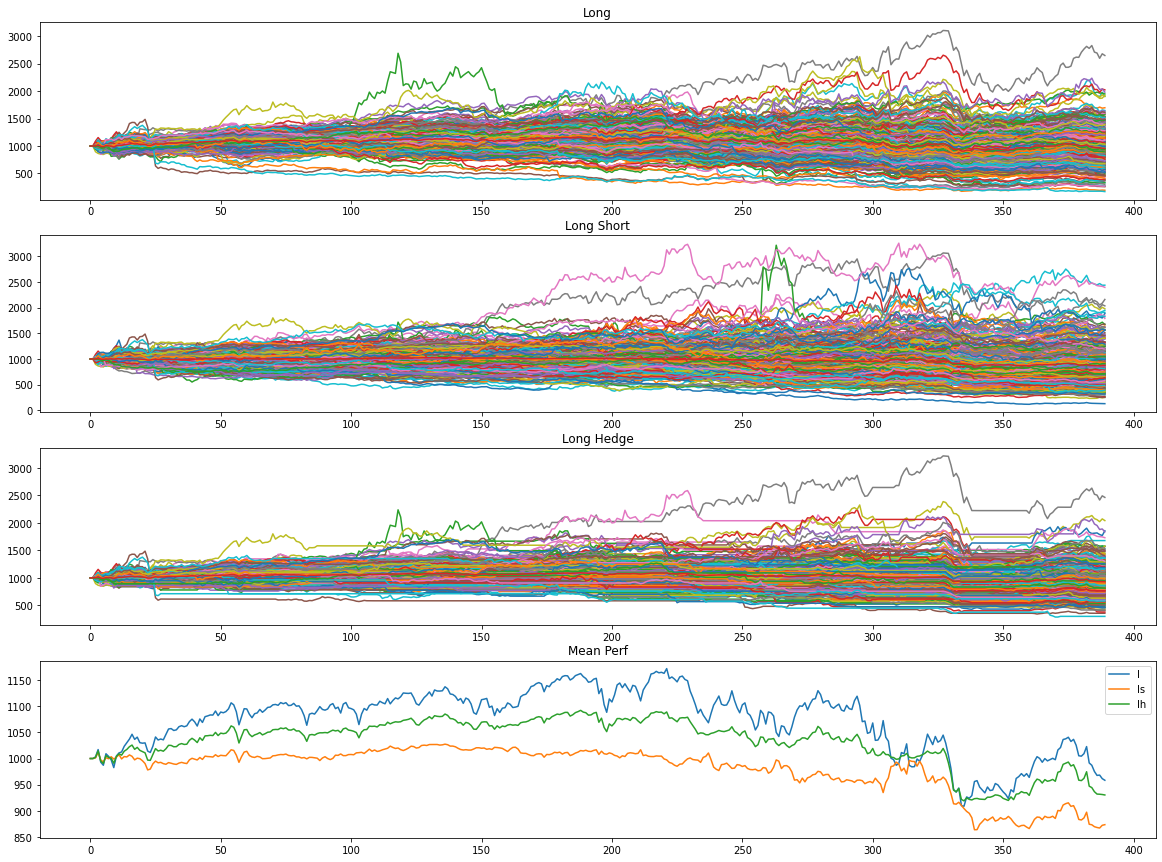

In [13]:
fig, ax = plt.subplots(4, 1, figsize=(20, 15))
ax[0].plot(df_port_l)
ax[0].set_title('Long')

ax[1].plot(df_port_ls)
ax[1].set_title('Long Short')

ax[2].plot(df_port_lh)
ax[2].set_title('Long Hedge')

ax[3].plot(df_port_l.port_mean)
ax[3].plot(df_port_ls.port_mean)
ax[3].plot(df_port_lh.port_mean)

ax[3].legend(['l', 'ls', 'lh'])
ax[3].set_title('Mean Perf')
;

In [18]:
df_port_ls

,AXP,AZO,BA,BAC,BALL,BAX,BBWI,BBY,BDX,BEN,...,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS,port_mean
0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
1,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
2,1007.255743,1002.864652,996.423480,1010.471269,1017.871910,1009.298880,1006.481476,989.406926,993.194504,990.075255,...,975.480956,1013.717636,992.097758,993.646882,1003.434141,990.503074,1019.689770,1015.065803,995.995995,1001.145043
3,1028.723892,998.920796,1074.197793,1034.645048,1020.817655,1004.531002,1017.650573,971.775510,997.172016,1021.040155,...,1002.956629,1043.655126,980.269340,1015.912162,1003.146539,979.428357,1049.292551,1062.831667,993.057114,1012.029569
4,1007.849351,1023.818320,1012.059702,1021.767242,1020.817655,1002.741313,1031.544242,877.217841,995.395206,978.871674,...,1009.138954,1026.207834,1009.192279,1004.898671,1002.954930,974.593729,1017.987269,1020.637405,976.879758,997.175031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,813.656685,802.558701,902.803201,558.888233,676.659020,765.086313,1811.131759,941.215284,899.947238,730.155302,...,837.665914,1354.252176,548.367741,1105.171796,877.430700,482.936642,1495.446331,942.471056,909.947969,869.479515
386,827.772540,795.842100,913.778343,566.813509,664.522950,751.924952,1793.749551,993.538660,897.277245,727.638965,...,832.716591,1344.089927,551.205109,1102.143097,881.066570,478.190618,1501.482404,936.155414,913.139670,867.940691
387,832.633608,805.687665,952.150365,569.179450,662.256754,761.141458,1845.375040,977.367391,907.281077,723.720916,...,845.735856,1319.684885,561.390934,1114.055646,904.667314,480.344648,1461.694769,937.515395,896.491449,866.910167
388,839.938955,813.020406,963.620669,569.860099,657.998286,768.552815,1847.775207,987.073464,913.888084,722.838226,...,855.138132,1343.646797,567.885115,1122.752574,914.782897,483.908825,1520.137536,936.323823,910.262581,872.155705


In [14]:
port_ls['A'][['close', 'is_macd_hold', 'wR_is_hold']].copy()

KeyError: 'A'

In [ ]:
_['wR_is_hold'] = _['wR_is_hold'].astype(bool)

In [ ]:
_.corr()

In [98]:
def get_vspan_plot(arr, val_filter):
    
    out = []
    for i in arr.index[1:-1]:
        if arr[i] == np.nan:
            pass
        if arr[i] == val_filter and arr[i-1] != val_filter:
            out.append(i)
        if arr[i] == val_filter and arr[i+1] != val_filter:
            out.append(i)
        else:
            pass
        
    if len(out) % 2 == 1:
        out = out[:-1]
    return np.array(out).reshape(int(len(out)/2), 2)

''

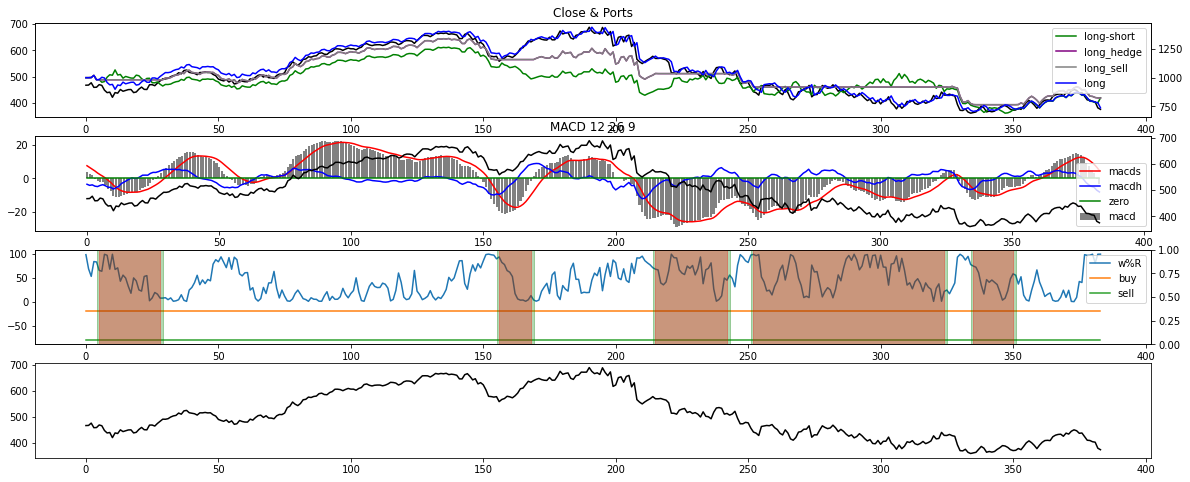

In [100]:
fig, ax = plt.subplots(4, 1, figsize=(20, 8))
ax[0].plot(df.close, color='black')

ax0 = ax[0].twinx()
ax0.plot(df.port_long_short, color='green')
ax0.plot(df.port_long_hedge, color='purple')
ax0.plot(df.port_long_sell, color='grey')
ax0.plot(df.port_long, color='blue')

ax0.legend(['long-short', 'long_hedge', 'long_sell', 'long'])
ax[0].set_title('Close & Ports')

ax1 = ax[1].twinx()
ax1.plot(df.close, color='black')
ax[1].bar(df.index, height=df.macd, color='grey')
ax[1].plot(df.macds, color='red')
ax[1].plot(df.macdh, color='blue')
ax[1].plot(df.index, list([0]*len(df)), color='green')
ax[1].set_title('MACD 12 26 9')
ax[1].legend(['macds', 'macdh', 'zero', 'macd'])

ax2 = ax[2].twinx()
ax[2].plot(df.williamsr_10)
ax[2].plot(list([-20]*len(df)))
ax[2].plot(list([-80]*len(df)))
ax[2].legend(['w%R', 'buy', 'sell'])

for item in get_vspan_plot(df.wR_is_hold, True):
    ax2.axvspan(item[0], item[1], color='green', alpha=.3)
for item in get_vspan_plot(df.wR_is_hold, False):
    ax2.axvspan(item[0], item[1], color='red', alpha=.3)
    
ax[3].plot(df.close, color='black')
;

In [70]:
5 % 2

1

In [43]:
def test(arr):
    out = []
    for i in arr:
        if i % 2 == 0:
            out.append(i)
        else:
            pass
            
    return out

In [44]:
test(range(0, 100))

[0,
 2,
 4,
 6,
 8,
 10,
 12,
 14,
 16,
 18,
 20,
 22,
 24,
 26,
 28,
 30,
 32,
 34,
 36,
 38,
 40,
 42,
 44,
 46,
 48,
 50,
 52,
 54,
 56,
 58,
 60,
 62,
 64,
 66,
 68,
 70,
 72,
 74,
 76,
 78,
 80,
 82,
 84,
 86,
 88,
 90,
 92,
 94,
 96,
 98]

In [45]:
df_p.is_wR_hold[10-1]

AttributeError: 'DataFrame' object has no attribute 'is_wR_hold'

In [ ]:
_ = get_vspan_plot(df_p.is_wR_hold, 'red', .5)

In [ ]:
_

In [109]:
len(_)

20

In [118]:
int(len(_)/2)

10

In [120]:
np.array(_).reshape(int(len(_)/2), 2)

array([[13, 13],
       [17, 24],
       [31, 44],
       [47, 49],
       [56, 58],
       [60, 61],
       [64, 64],
       [68, 68],
       [70, 72],
       [74, 89]])